In [8]:
import arus
import pandas as pd
import numpy as np
import logging
import time
arus.dev.set_default_logging()

In [9]:
# Get device addr
scanner = arus.plugins.metawear.MetaWearScanner()
addrs = scanner.get_nearby_devices(max_devices=3)
addrs = addrs[0:3]

[INFO]2020-02-05 19:09:54,488 <P9964-MainThread> Scanning metawear devices nearby...
[INFO]2020-02-05 19:09:55,493 <P9964-MainThread> Scanning metawear devices nearby...
[INFO]2020-02-05 19:09:56,495 <P9964-MainThread> Scanning metawear devices nearby...


In [10]:
# prepare streams
streams = []
ref_st = pd.Timestamp.now()
for addr in addrs:
    generator = arus.plugins.metawear.MetaWearAccelDataGenerator(
        addr, sr=50, grange=8, buffer_size=100)
    segmentor = arus.segmentor.SlidingWindowSegmentor(
        window_size=2, ref_st=ref_st)
    stream = arus.Stream(generator, segmentor,
                         name='metawear-stream-{}'.format(addr))
    streams.append(stream)


In [11]:
# start stream
results = {}
for stream in streams:
    stream.start()
    results[stream._name] = []


In [12]:
done = [False] * len(streams)
while True:
    for stream in streams:
        for data, st, et, _, _, name in stream.get_iterator():
            data['ST'] = st
            data['ET'] = et
            i = streams.index(stream)
            logging.info('data from: {}, {}'.format(
                name, i))
            results[name].append(data)
            if len(results[name]) == 20:
                done[i] = True
            break
    if np.all(done):
        break

for stream in streams:
    stream.stop()

combined = []
for name, result in results.items():
    name = name.replace(':', '')
    result = pd.concat(result, sort=False)
    combined.append(result)

combined = pd.concat(combined, sort=False)



[INFO]2020-02-05 19:09:58,762 <P9964-metawear-stream-D5:D2:01:2B:E7:6D-loading> New metawear connected: MetaWearClient, D5:D2:01:2B:E7:6D: {'model': '5', 'hardware': '0.3', 'manufacturer': 'MbientLab Inc', 'serial': '031371', 'firmware': '1.5.0'}
[INFO]2020-02-05 19:09:58,768 <P9964-metawear-stream-D5:D2:01:2B:E7:6D-loading> starting accelerometer module...
[INFO]2020-02-05 19:09:58,769 <P9964-metawear-stream-D5:D2:01:2B:E7:6D-loading> Waiting for accelerometer callback to start...
[INFO]2020-02-05 19:09:58,800 <P9964-metawear-stream-E6:F8:37:54:03:87-loading> New metawear connected: MetaWearClient, E6:F8:37:54:03:87: {'model': '5', 'hardware': '0.3', 'manufacturer': 'MbientLab Inc', 'serial': '0316A5', 'firmware': '1.5.0'}
[INFO]2020-02-05 19:09:58,803 <P9964-metawear-stream-E6:F8:37:54:03:87-loading> starting accelerometer module...
[INFO]2020-02-05 19:09:58,804 <P9964-metawear-stream-E6:F8:37:54:03:87-loading> Waiting for accelerometer callback to start...
[INFO]2020-02-05 19:09:58,

 ## Analyze results
 ### Check the first sample timestamp
 1. **referenced start time**: The start time used as a reference to segment the incoming data. This value is set before setting up and start the streams.
 2. **first sample timestamp**: The timestamp of the first sample received from each device. This timestamp has been synced with the computer clock when receiving the data.
 3. **first sample device timestamp**: The timestamp of the first sample received from each device. This timestamp has not been synced with the computer clock when receiving the data.

In [13]:
first_sample = combined.groupby(by=['MAC_ADDRESS']).apply(
    lambda df: df[['HEADER_TIME_STAMP', 'NO_FIX']].iloc[0, :])
first_sample = first_sample.rename(
    columns={'HEADER_TIME_STAMP': 'first sample timestamp', 'NO_FIX': 'first sample device timestamp'})
first_sample = first_sample.sort_values(by=['first sample timestamp'])
first_sample['referenced start time'] = ref_st
first_sample['diff_ref (s)'] = arus.Moment.get_durations(
    first_sample['referenced start time'], first_sample['first sample timestamp'])
first_sample['diff_device (s)'] = arus.Moment.get_durations(
    first_sample['first sample device timestamp'],
    first_sample['first sample timestamp'])
first_sample.transpose()

MAC_ADDRESS,D5:D2:01:2B:E7:6D,E6:F8:37:54:03:87,D2:C6:AF:2B:DB:22
0,,,
first sample timestamp,2020-02-05 19:09:58.882267,2020-02-05 19:09:58.962483,2020-02-05 19:10:02.311738
first sample device timestamp,2020-02-05 19:09:58.883000,2020-02-05 19:09:58.963000,2020-02-05 19:10:02.306000
referenced start time,2020-02-05 19:09:57.512062,2020-02-05 19:09:57.512062,2020-02-05 19:09:57.512062
diff_ref (s),1.3702,1.45042,4.79968
diff_device (s),-0.000733,-0.000517,0.005738


 ### Check number of samples in each segments

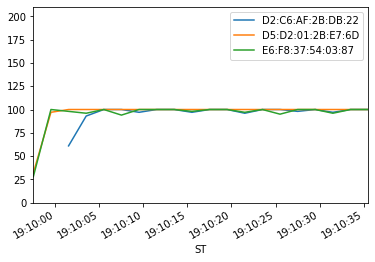

In [14]:
count_segment = combined.groupby(
    by=['MAC_ADDRESS', 'ST']).size().to_frame(name='# of samples').reset_index(drop=False)
count_segment = count_segment.pivot(
    columns='MAC_ADDRESS', index='ST', values=['# of samples'])
count_segment.columns = sorted(addrs)
count_segment.reset_index(drop=False, inplace=True)
count_segment.plot(x='ST', kind='line', ylim=(0, 210))